In [2]:
import pandas as pd
from gensim.models import LdaModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
file = pd.read_table('../steps/discretized_9.features', dtype=str)

In [4]:
CIN = pd.read_table("/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt")

In [5]:
CIN.head()

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,1,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,2,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,3,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,4,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,5,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [6]:
lda = LdaModel.load(f'../steps/gensim/lda/lda_t5_f10.model')
file = pd.read_table('../steps/discretized_9.features', dtype=str)
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

In [7]:
topics = lda.get_document_topics(bow = bow_corpus, minimum_probability = 0)
columns = [[],[],[],[],[]]
for topic in topics:
    for w in topic:
        columns[w[0]].append(w[1])
# print(columns)
new_df = pd.DataFrame(file['Sample'])
new_df['Chr'] = file['Chr']
new_df['Sign1'] = columns[0]
new_df['Sign2'] = columns[1]
new_df['Sign3'] = columns[2]
new_df['Sign4'] = columns[3]
new_df['Sign5'] = columns[4]
new_df = new_df.sort_values(by='Chr')
new_df

,Sample,Chr,Sign1,Sign2,Sign3,Sign4,Sign5
0,TCGA-02-0001,1,0.005398,0.648073,0.007934,0.004113,0.334482
106996,TCGA-E2-A10A,1,0.005281,0.007766,0.007761,0.972196,0.006996
106973,TCGA-E2-A109,1,0.005230,0.007692,0.007687,0.972461,0.006930
106950,TCGA-E2-A108,1,0.973949,0.007621,0.007616,0.003948,0.006866
13823,TCGA-25-2396,1,0.005480,0.975028,0.008055,0.004175,0.007261
...,...,...,...,...,...,...,...
38050,TCGA-A2-A0CT,9,0.777692,0.203658,0.007707,0.003995,0.006948
158662,TCGA-S9-A7R1,9,0.005211,0.007664,0.007659,0.003970,0.975496
96930,TCGA-DD-AACV,9,0.005315,0.007816,0.007811,0.004049,0.975009
20455,TCGA-37-4141-a,9,0.973921,0.007629,0.007624,0.003952,0.006873


In [8]:
def create_heatmap(model, df):
    topics = lda.get_document_topics(bow = bow_corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Chr'])
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    new_df = new_df.set_index('Chr')
    new_df = new_df.transpose()
    return new_df
    # ax = sns.heatmap(new_df, vmin=0, vmax=1)
    # plt.show()


In [45]:
heatmap_df = create_heatmap(lda, file)

In [47]:
heatmap_df

Chr,1,1,1,1,1,1,1,1,1,1,...,23,23,23,23,23,23,23,23,23,23
1,0.005398,0.005339,0.005319,0.005256,0.005725,0.973330,0.005079,0.005223,0.005192,0.005303,...,0.005190,0.005182,0.973786,0.005307,0.973526,0.005331,0.973552,0.005215,0.005257,0.005224
2,0.648039,0.007851,0.007823,0.976052,0.701831,0.007802,0.007469,0.007681,0.007636,0.975837,...,0.007632,0.007621,0.007669,0.007805,0.007745,0.007840,0.007737,0.007669,0.007731,0.007683
3,0.007934,0.290982,0.007817,0.007724,0.008414,0.007797,0.007464,0.976197,0.007631,0.007794,...,0.007627,0.007616,0.007664,0.007800,0.007740,0.975705,0.007732,0.976234,0.007726,0.976190
4,0.004113,0.004067,0.004052,0.004004,0.004361,0.004042,0.003869,0.003979,0.972662,0.004040,...,0.972674,0.003948,0.003973,0.004043,0.004012,0.004061,0.004008,0.003973,0.004005,0.003980
5,0.334516,0.691761,0.974989,0.006964,0.279669,0.007029,0.976119,0.006920,0.006879,0.007026,...,0.006876,0.975633,0.006909,0.975045,0.006977,0.007063,0.006971,0.006909,0.975281,0.006922


In [13]:
clusters = file['Chr'].unique()
palette = list(sns.color_palette("viridis", 23).as_hex())
color_mapping = dict(zip(clusters, palette))
cluster_colors = file['Chr'].map(color_mapping)

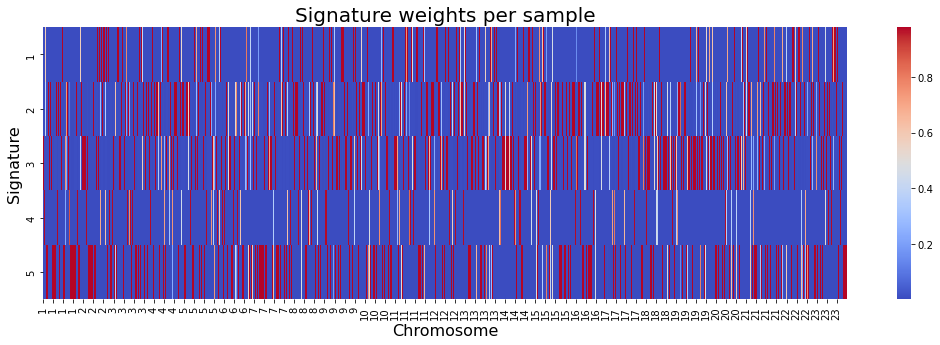

In [51]:
plt.figure(figsize=(18,5))
ax = sns.heatmap(heatmap_df, cmap='coolwarm')
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Chromosome', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Signature weights per sample", fontsize=20)
plt.show()